In [570]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [571]:
# Define the path to the CSV file
file_path = './data/sales_train_evaluation.csv'

# Read the CSV file into a DataFrame
sales_df = pd.read_csv(file_path)


In [572]:
# Define the path to the CSV file
file_path = './data/calendar.csv'

# Read the CSV file into a DataFrame
calendar_df = pd.read_csv(file_path)


In [573]:
# Define the path to the CSV file
file_path = './data/sell_prices.csv'

# Read the CSV file into a DataFrame
prices_df = pd.read_csv(file_path)


In [574]:
sales_df.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,7,0,6,0,15,5,4,1,40,32
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,0,0,0,0,0,1,0
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,1,0,2,1,1,0,0,1


In [575]:
sales_df.shape

(30490, 1947)

In [576]:
# Reshaping the data from wide to long format, as to use days easier

sales_long = sales_df.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='day',
    value_name='sales'
)

In [577]:
# Set the date column as the index for easier lookup
#calendar_df.set_index('date', inplace=True)


In [578]:
sales_long["cat_id"].value_counts()

cat_id
FOODS        27892170
HOUSEHOLD    20322270
HOBBIES      10966650
Name: count, dtype: int64

In [579]:
hobbies_sales_long = sales_long[sales_long['cat_id'] == 'HOBBIES']

In [580]:
hobbies_sales_long.shape

(10966650, 8)

In [581]:
ca_hobbies_sales_long = hobbies_sales_long[hobbies_sales_long['state_id'] == 'CA']

In [582]:
ca_hobbies_sales_long.shape

(4386660, 8)

In [583]:
## All SKU in Hobbie Department, within Primary Store in California
# About 1.1 M entries

alpha_ca_hobbies_sales_long = ca_hobbies_sales_long[ca_hobbies_sales_long['store_id'] == 'CA_1']

In [584]:
alpha_ca_hobbies_sales_long.shape

(1096665, 8)

In [585]:
## A specific single SKU in Hobbie Department, within Primary Store in California

filtered_sales_df = alpha_ca_hobbies_sales_long[alpha_ca_hobbies_sales_long['item_id'] == 'HOBBIES_1_001']

In [586]:
filtered_sales_df.shape

(1941, 8)

In [587]:
filtered_sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
30490,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
60980,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
91470,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
121960,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0


In [588]:
# Convert the 'day' column to an integer representing the day number
filtered_sales_df['day_num'] = filtered_sales_df['day'].str.extract('d_(\d+)').astype(int)

# Assume the first day is 2011-01-29, add the day numbers to get actual dates
start_date = datetime.datetime(2011, 1, 29)
filtered_sales_df['date'] = filtered_sales_df['day_num'].apply(lambda x: start_date + datetime.timedelta(days=x-1))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rafae\AppData\Local\Temp\ipykernel_19636\939334016.py:2: SyntaxWarning: invalid escape sequence '\d'
  filtered_sales_df['day_num'] = filtered_sales_df['day'].str.extract('d_(\d+)').astype(int)
C:\Users\rafae\AppData\Local\Temp\ipykernel_19636\939334016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales_df['day_num'] = filtered_sales_df['day'].str.extract('d_(\d+)').astype(int)
C:\Users\rafae\AppData\Local\Temp\ipykernel_19636\939334016.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [589]:
# Sort by id and date before creating rolling features
filtered_sales_df = filtered_sales_df.sort_values(by=['id', 'date'])

# Create a 7-day rolling average
filtered_sales_df['rolling_avg_7'] = filtered_sales_df.groupby('id')['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean().round(2))
filtered_sales_df['rolling_avg_30'] = filtered_sales_df.groupby('id')['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean().round(2))



In [590]:
# Defining function used below, to slice and therefore standardize formats between dfs

def day_slicer(row):
    slice_list = row.split("_")
    return slice_list[1]

In [591]:

calendar_df['d'] = calendar_df['d'].apply(day_slicer)

calendar_df.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,1,NaN,NaN,NaN,NaN,0,0,0


In [592]:
filtered_sales_df['date'] = pd.to_datetime(single_alpha_ca_hobbies_sales_long['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [593]:
# This function fecthes the following attributes from calendar_df and pastes them to sales_df
# snap, based on state
# weekday and if is_weekend
# events of each day, if any

def fetch_calendar_info(row):
    # Filter calendar_df for the matching date
    calendar_row = calendar_df[calendar_df['date'] == row['date']]
    
    # Retrieve the relevant snap value based on the state
    if not calendar_row.empty:
        if row['state_id'] == 'CA':
            row['snap'] = calendar_row['snap_CA'].values[0]
        elif row['state_id'] == 'TX':
            row['snap'] = calendar_row['snap_TX'].values[0]
        elif row['state_id'] == 'WI':
            row['snap'] = calendar_row['snap_WI'].values[0]
        
    # Fetching add weekday from calendar_df
        row['weekday'] = calendar_row['weekday'].values[0]

    # Fetching Event_1
        row["event_name_1"] = calendar_row["event_name_1"].values[0]
        row["event_type_1"] = calendar_row["event_type_1"].values[0]

    # Fetching Event_2, if it is not NaN
        row["event_name_2"] = calendar_row["event_name_2"].values[0]
        row["event_type_2"] = calendar_row["event_type_2"].values[0]
    
    else:
        
    # Empty Error Handling
        row['snap'] = None  # or a default value
        row['weekday'] = None
        row["event_name_1"] = None
        row["event_type_1"] = None
        row["event_name_2"] = None
        row["event_type_2"] = None
        

    # Flag Weekend (Binary)
    if row["weekday"] == "Saturday" or row["weekday"] == "Sunday":
        row["is_weekend"] = 1
    else:
        row["is_weekend"] = 0

    return row

In [594]:
filtered_sales_df = filtered_sales_df.apply(fetch_calendar_info, axis=1)

In [595]:
filtered_sales_df.tail(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,day_num,date,rolling_avg_7,rolling_avg_30,snap,weekday,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend
59028640,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1937,0,1937,2016-05-18,0.86,1.10,0,Wednesday,NaN,NaN,NaN,NaN,0
59059130,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1938,3,1938,2016-05-19,1.29,1.17,0,Thursday,NaN,NaN,NaN,NaN,0
59089620,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1939,3,1939,2016-05-20,1.43,1.23,0,Friday,NaN,NaN,NaN,NaN,0
59120110,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1940,0,1940,2016-05-21,0.86,1.13,0,Saturday,NaN,NaN,NaN,NaN,1
59150600,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1941,1,1941,2016-05-22,1.00,1.17,0,Sunday,NaN,NaN,NaN,NaN,1


In [596]:
calendar_df.tail(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1968,2016-06-19,11621,Sunday,2,6,2016,1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


_________________________________

In [597]:
#### MODEL STARTS HERE

In [598]:
# Example: Assume 'sales' is your target variable
target_column = 'sales'
X = filtered_sales_df.drop(columns=[target_column])
y = filtered_sales_df[target_column]

In [599]:
## XGBoost works with numericals

X = pd.get_dummies(X)

In [600]:
# Training the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [601]:
X_train['day'] = X_train['date'].dt.day
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year

X_test['day'] = X_test['date'].dt.day
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year

# Drop the original 'date' column after extracting features
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

In [602]:
# Initialize the Model: Set up the model with default parameters or customize them as needed.

model = XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression
    n_estimators=100,              # Number of trees
    learning_rate=0.1,             # Step size shrinkage
    max_depth=5,                   # Maximum depth of trees
    random_state=42,                # Seed for reproducibility
    enable_categorical=True
)

In [603]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [604]:
y_pred = model.predict(X_test)

In [605]:
non_zero_indices = y_test != 0

In [606]:
# MAE, Measures the average magnitude of errors in predictions, without considering their direction. Lower is better.
mae = mean_absolute_error(y_test, y_pred)

# RMSE, Measures the average magnitude of errors, with a larger penalty for bigger errors. Lower is better.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R2, Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. 
# A higher value, closer to 1, is generally better.
r2 = r2_score(y_test, y_pred)

# MAPE, measures the average percentage error and is useful for understanding error relative to actual values.
# mape = np.mean(np.abs((y_test_no_zero - y_pred) / y_test)) * 100
mape = np.mean(np.abs((y_test[non_zero_indices] - y_pred[non_zero_indices]) / y_test[non_zero_indices])) * 100

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error: 0.3356369046235797
Root Mean Squared Error: 0.5770355177413362
R-squared: 0.2966279746297745
Mean Absolute Percentage Error (MAPE): 54.21120161550087


_________________________________

In [607]:
## EXAMINING RESULTS

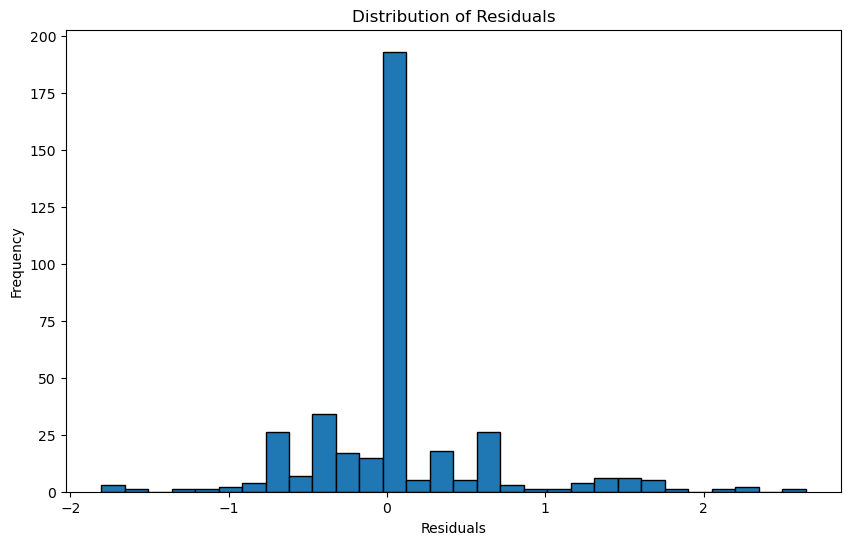

In [608]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

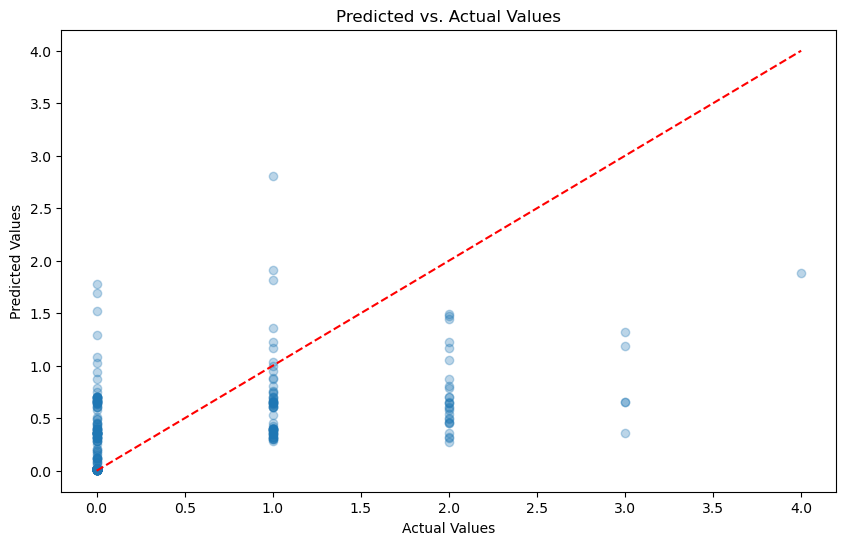

In [609]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()